# 词汇的星空——词向量（Word Vector）技术

在这节课中，我们学习了如何通过人工神经网络得到单词的向量表达。

首先，我们构建了一个简单的NGram语言模型，根据N个历史词汇预测下一个单词，从而得到每一个单词的向量表示。我们用小说《三体》为例，展示了我们的词向量嵌入效果。

其次，我们学习了如何使用成熟的Google开发的Word2Vec包来进行大规模语料的词向量训练，以及如何加载已经训练好的词向量，从而利用这些词向量来做一些简单的运算和测试。

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [2]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载‘结巴’中文分词软件包

import jieba

#加载正则表达式处理的包
import re

%matplotlib inline

## 一、NGram 词向量模型

NGram词向量模型的原理是利用一个人工神经网络来根据前N个单词来预测下一个单词，从而得到每个单词的词向量

### 1. 文本预处理

我们以刘慈欣著名的科幻小说《三体》为例，来展示利用NGram模型训练词向量的方法

预处理分为两个步骤：

1、读取文件

2、分词

3、将语料划分为N＋1元组，准备好训练用数据

在这里，我们并没有去除标点符号，一是为了编程简洁，而是考虑到分词会自动将标点符号当作一个单词处理，因此不需要额外考虑。

#### 1). 读入原始文件，筛掉所有标点符号

In [2]:
#读入原始文件

f = open("三体.txt", 'r')
# 若想加快运行速度，使用下面的语句（选用了三体的其中一章）：
#f = open("3body.txt", 'r') 
text = str(f.read())
f.close()

text

'疯狂年代\n\n中国，1967年。\n\n“红色联合”对“四?二八兵团”总部大楼的攻击已持续了两天，他们的旗帜在大楼周围躁动地飘扬着，仿佛渴望干柴的火种。“红色联合”的指挥官心急如焚，他并不惧怕大楼的守卫者，那二百多名“四?二八”战士，与诞生于l966年初、经历过大检阅和大串联的“红色联合”相比要稚嫩许多。他怕的是大楼中那十几个大铁炉子，里面塞满了烈性炸药，用电雷管串联起来，他看不到它们，但能感觉到它们磁石般的存在，开关一合，玉石俱焚，而“四?二八”的那些小红卫兵们是有这个精神力量的。比起已经在风雨中成熟了许多的第一代红卫兵，新生的造反派们像火炭上的狼群，除了疯狂还是疯狂。\n\n大楼顶上出现了一个娇小的身影，那个美丽的女孩子挥动着一面“四?二八”的大旗，她的出现立刻招来了一阵杂乱的枪声，射击的武器五花八门，有陈旧的美式卡宾枪、捷克式机枪和三八大盖，也有崭新的制式步枪和冲锋枪——后者是在“八月社论”发表之后从军队中偷抢来的（注：1967年8月《红旗》杂志发表“揪军内一小撮”的社论，使冲击军区、抢夺军队枪支弹药的事件愈演愈烈，全国范围的武斗也进入高潮。）——连同那些梭标和大刀等冷兵器，构成了一部浓缩的近现代史……“四?二八”的人在前面多次玩过这个游戏，在楼顶上站出来的人，除了挥舞旗帜外，有时还用喇叭筒喊口号或向下撒传单，每次他们都能在弹雨中全身而退，为自己挣到了崇高的荣誉。这次出来的女孩儿显然也相信自己还有那样的幸运她挥舞着战旗，挥动着自己燃烧的青春，敌人将在这火焰中化为灰烬，理想世界明天就会在她那沸腾的热血中诞生……她陶醉在这鲜红灿烂的梦幻中，直到被一颗步枪子弹洞穿了胸膛，十五岁少女的胸膛是那么柔嫩，那颗子弹穿过后基本上没有减速，在她身后的空中发出一声啾鸣。年轻的红卫兵同她的旗帜一起从楼顶落下，她那轻盈的身体落得甚至比旗帜还慢，仿佛小鸟眷恋着天空。\n\n“红色联合”的战士们欢呼起来，几个人冲到楼下，掀开四．二八的旗帜，抬起下面纤小的遗体，作为一个战利品炫耀地举了一段，然后将她高高地扔向大院的铁门，铁门上带尖的金属栅条大部分在武斗初期就被抽走当梭标了，剩下的两条正好挂住了她，那一瞬间，生命似乎又回到了那个柔软的躯体。红色联合的红卫兵们退后一段距离，将那个挂在高处的躯体当靶子练习射击，密集的子弹对她来说已柔和如雨，不再带来任何感觉，她那春藤般的手臂不时轻挥一下，仿佛

#### 2)、分词，并去掉标点符号

In [10]:
# 分词
temp = jieba.lcut(text)
words = []
for i in temp:
    #过滤掉所有的标点符号
    i = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", i)
    if len(i) > 0:
        words.append(i)
print(len(words))
words

98853


['疯狂',
 '年代',
 '中国',
 '1967',
 '年',
 '红色',
 '联合',
 '对',
 '四',
 '二八',
 '兵团',
 '总部',
 '大楼',
 '的',
 '攻击',
 '已',
 '持续',
 '了',
 '两天',
 '他们',
 '的',
 '旗帜',
 '在',
 '大楼',
 '周围',
 '躁动',
 '地',
 '飘扬',
 '着',
 '仿佛',
 '渴望',
 '干柴',
 '的',
 '火种',
 '红色',
 '联合',
 '的',
 '指挥官',
 '心急如焚',
 '他',
 '并',
 '不',
 '惧怕',
 '大楼',
 '的',
 '守卫者',
 '那',
 '二百多名',
 '四',
 '二八',
 '战士',
 '与',
 '诞生',
 '于',
 'l966',
 '年初',
 '经历',
 '过大',
 '检阅',
 '和',
 '大串联',
 '的',
 '红色',
 '联合',
 '相比',
 '要',
 '稚嫩',
 '许多',
 '他',
 '怕',
 '的',
 '是',
 '大楼',
 '中',
 '那',
 '十几个',
 '大铁',
 '炉子',
 '里面',
 '塞满',
 '了',
 '烈性',
 '炸药',
 '用电',
 '雷管',
 '串联',
 '起来',
 '他',
 '看不到',
 '它们',
 '但',
 '能',
 '感觉',
 '到',
 '它们',
 '磁石',
 '般的',
 '存在',
 '开关',
 '一合',
 '玉石俱焚',
 '而',
 '四',
 '二八',
 '的',
 '那些',
 '小',
 '红卫兵',
 '们',
 '是',
 '有',
 '这个',
 '精神力量',
 '的',
 '比起',
 '已经',
 '在',
 '风雨',
 '中',
 '成熟',
 '了',
 '许多',
 '的',
 '第一代',
 '红卫兵',
 '新生',
 '的',
 '造反派',
 '们',
 '像',
 '火炭',
 '上',
 '的',
 '狼群',
 '除了',
 '疯狂',
 '还是',
 '疯狂',
 '大楼',
 '顶上',
 '出现',
 '了',
 '一个',
 '娇小',
 '的',
 '身影',
 '那个',
 '美

#### 3)、构建N+1元组作为训练数据对

In [11]:
# 构建三元组列表.  每一个元素为： ([ i-2位置的词, i-1位置的词 ], 下一个词)
# 我们选择的Ngram中的N，即窗口大小为2
trigrams = [([words[i], words[i + 1]], words[i + 2]) for i in range(len(words) - 2)]
# 打印出前三个元素看看
print(trigrams[:3])

[(['疯狂', '年代'], '中国'), (['年代', '中国'], '1967'), (['中国', '1967'], '年')]


#### 4). 将每个单词进行编码，构造词典

In [12]:
# 得到词汇表
vocab = set(words)
print(len(vocab))
# 两个字典，一个根据单词索引其编号，一个根据编号索引单词
#word_to_idx中的值包含两部分，一部分为id，另一部分为单词出现的次数
#word_to_idx中的每一个元素形如：{w:[id, count]}，其中w为一个词，id为该词的编号，count为该单词在words全文中出现的次数
word_to_idx = {} 
idx_to_word = {}
ids = 0

#对全文循环，构建这两个字典
for w in words:
    cnt = word_to_idx.get(w, [ids, 0])
    if cnt[1] == 0:
        ids += 1
    cnt[1] += 1
    word_to_idx[w] = cnt
    idx_to_word[ids] = w

13876


In [13]:
word_to_idx

{'痒': [13283, 1],
 '侧面': [12858, 1],
 '接近': [4357, 13],
 '连续': [2065, 7],
 '十倍': [12425, 1],
 '进人': [6452, 4],
 '英勇': [1289, 2],
 '玩游戏': [4950, 3],
 '贮存': [13478, 1],
 '空间': [4312, 20],
 '次': [3238, 4],
 '不分': [5762, 1],
 '单薄': [7580, 2],
 '远远地': [5087, 3],
 '体会': [6817, 1],
 '序章': [1926, 1],
 '用大史': [12538, 1],
 '褐燕': [11992, 1],
 '条例': [3021, 1],
 '轨迹': [9066, 6],
 '第一个': [4624, 10],
 '谈谈': [2618, 3],
 '最终目标': [10275, 2],
 '外形': [9931, 3],
 '携带': [2408, 6],
 '剩下': [294, 27],
 '恒星系': [11020, 1],
 '资料室': [10609, 4],
 '手拂脸': [13281, 1],
 '没伤': [2163, 1],
 '寒颤': [6924, 1],
 '月牙': [10029, 2],
 '排九米': [6547, 1],
 '顶部': [6011, 6],
 '六个': [1602, 3],
 '分高': [11449, 1],
 '不时': [321, 9],
 '进口': [7760, 2],
 '半月': [10028, 1],
 '靠近': [2144, 2],
 '首长': [3469, 8],
 '菜': [6351, 2],
 '相当': [5059, 23],
 '幸福': [960, 2],
 '一卜': [4483, 1],
 '无关': [2632, 8],
 '锥形': [13376, 1],
 '组装': [10816, 1],
 '启动': [3276, 21],
 '30': [3243, 1],
 '讲述': [4978, 10],
 '睁': [6110, 1],
 '空箱子': [1325, 1],
 '幽灵': [4676, 21],
 

### 2、构造模型并训练

#### 1). 构造NGram神经网络模型

我们构造了一个三层的网络：

1、输入层：embedding层，这一层的作用是：先将输入单词的编号映射为一个one hot编码的向量，形如：001000，维度为单词表大小。
然后，embedding会通过一个线性的神经网络层映射到这个词的向量表示，输出为embedding_dim

2、线性层，从embedding_dim维度到128维度，然后经过非线性ReLU函数

3、线性层：从128维度到单词表大小维度，然后log softmax函数，给出预测每个单词的概率

In [14]:
class NGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  #嵌入层
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #线性层
        self.linear2 = nn.Linear(128, vocab_size) #线性层

    def forward(self, inputs):
        #嵌入运算，嵌入运算在内部分为两步：将输入的单词编码映射为one hot向量表示，然后经过一个线性层得到单词的词向量
        #inputs的尺寸为：1*context_size
        embeds = self.embeddings(inputs)
        #embeds的尺寸为: context_size*embedding_dim
        embeds = embeds.view(1, -1)
        #此时embeds的尺寸为：1*embedding_dim
        # 线性层加ReLU
        out = self.linear1(embeds)
        out = F.relu(out)
        #此时out的尺寸为1*128
        
        # 线性层加Softmax
        out = self.linear2(out)
        #此时out的尺寸为：1*vocab_size
        log_probs = F.log_softmax(out)
        return log_probs
    def extract(self, inputs):
        embeds = self.embeddings(inputs)
        return embeds

#### 2). 开始训练模型

In [15]:
losses = [] #纪录每一步的损失函数
criterion = nn.NLLLoss() #运用负对数似然函数作为目标函数（常用于多分类问题的目标函数）
model = NGram(len(vocab), 10, 2) #定义NGram模型，向量嵌入维数为10维，N（窗口大小）为2
optimizer = optim.SGD(model.parameters(), lr=0.001) #使用随机梯度下降算法作为优化器

#循环100个周期
for epoch in range(20):
    total_loss = torch.Tensor([0])
    for context, target in trigrams:

        # 准备好输入模型的数据，将词汇映射为编码
        context_idxs = [word_to_idx[w][0] for w in context]
        
        # 包装成PyTorch的Variable
        context_var = Variable(torch.LongTensor(context_idxs))

        # 清空梯度：注意PyTorch会在调用backward的时候自动积累梯度信息，故而每隔周期要清空梯度信息一次。
        optimizer.zero_grad()

        # 用神经网络做计算，计算得到输出的每个单词的可能概率对数值
        log_probs = model(context_var)

        # 计算损失函数，同样需要把目标数据转化为编码，并包装为Variable
        loss = criterion(log_probs, Variable(torch.LongTensor([word_to_idx[target][0]])))

        # 梯度反传
        loss.backward()
        
        # 对网络进行优化
        optimizer.step()
        
        # 累加损失函数值
        total_loss += loss.data
    losses.append(total_loss)
    print('第{}轮，损失函数为：{:.2f}'.format(epoch, total_loss.numpy()[0]))

第0轮，损失函数为：804126.31
第1轮，损失函数为：739285.12
第2轮，损失函数为：723876.69
第3轮，损失函数为：715279.88
第4轮，损失函数为：708743.38
第5轮，损失函数为：702955.50
第6轮，损失函数为：697468.06
第7轮，损失函数为：692082.88
第8轮，损失函数为：686681.12
第9轮，损失函数为：681232.12
第10轮，损失函数为：675680.44
第11轮，损失函数为：670008.12
第12轮，损失函数为：664191.12
第13轮，损失函数为：658221.44
第14轮，损失函数为：652113.56
第15轮，损失函数为：645844.06
第16轮，损失函数为：639432.12
第17轮，损失函数为：632883.12
第18轮，损失函数为：626229.62
第19轮，损失函数为：619454.62


### 3. 结果展示
#### 1). 将向量投影到二维平面进行可视化

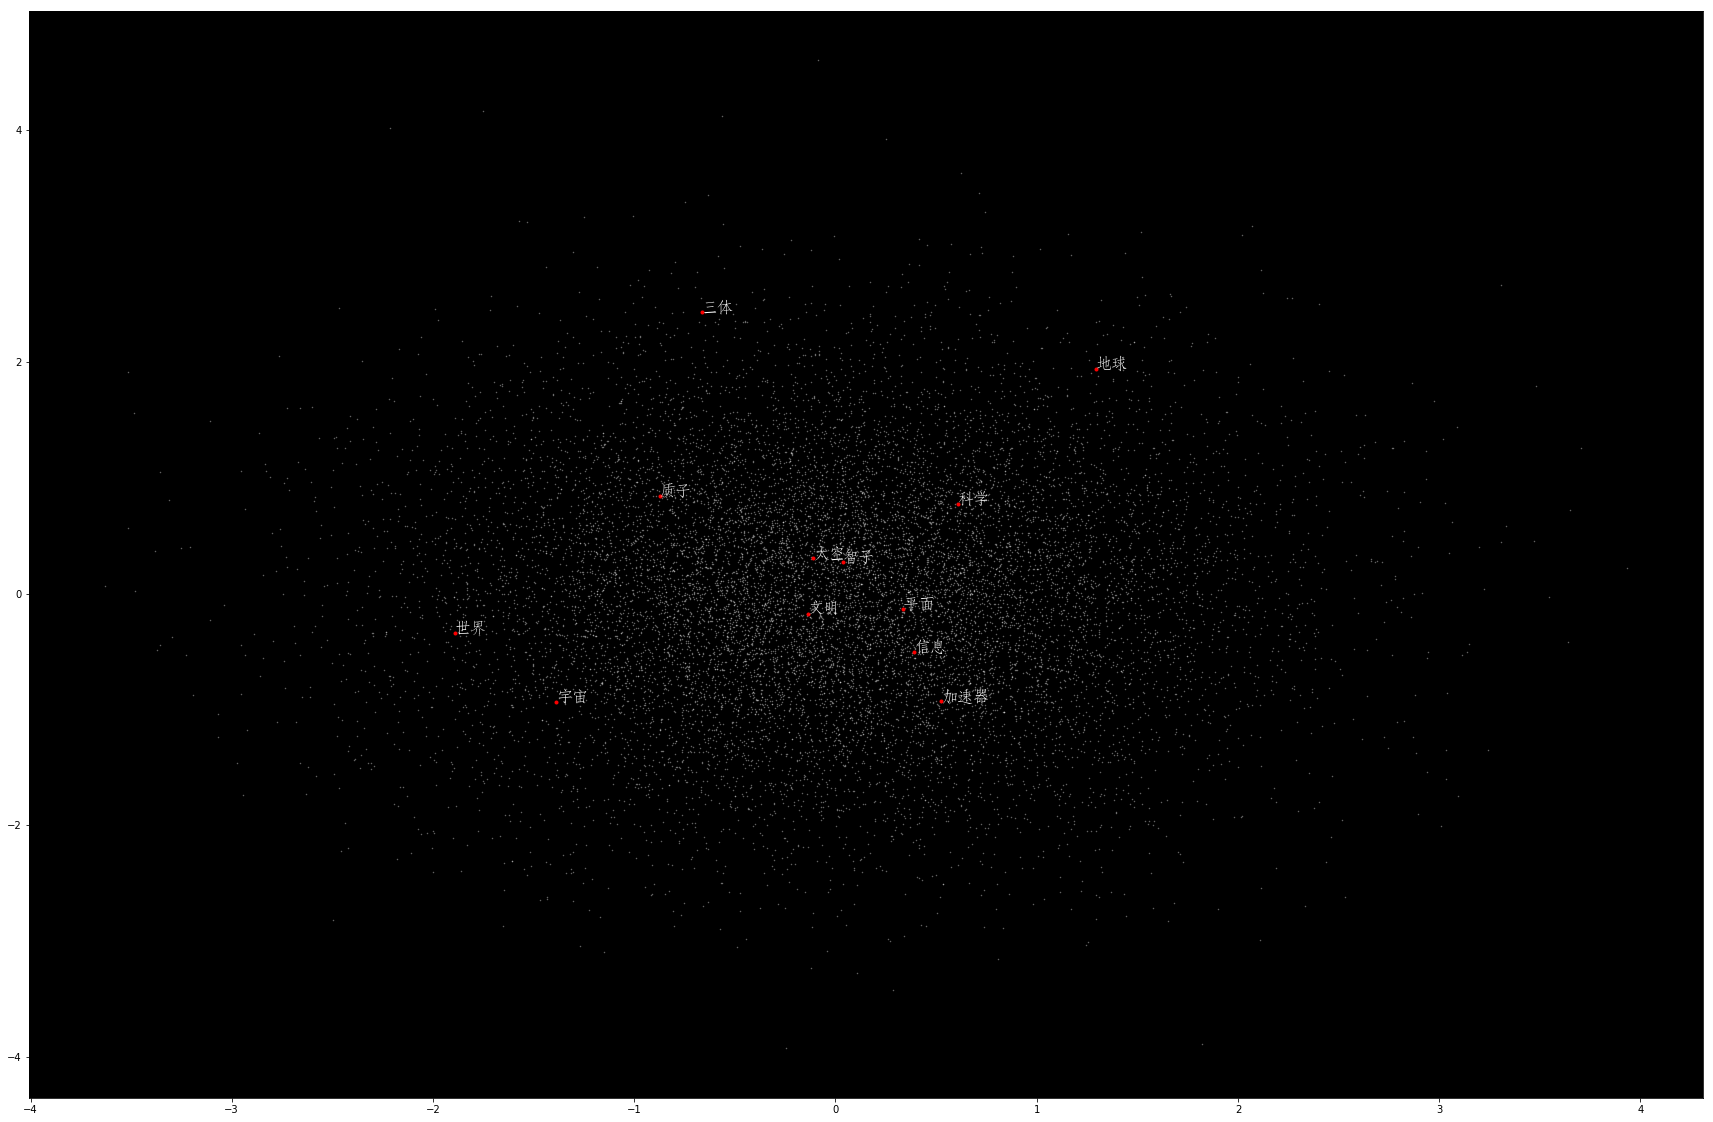

In [16]:
# 从训练好的模型中提取每个单词的向量
vec = model.extract(Variable(torch.LongTensor([v[0] for v in word_to_idx.values()])))
vec = vec.data.numpy()

# 利用PCA算法进行降维
X_reduced = PCA(n_components=2).fit_transform(vec)


# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (30, 20))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.4, color = 'black')


# 绘制几个特殊单词的向量
words = ['智子', '地球', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '信息']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
for w in words:
    if w in word_to_idx:
        ind = word_to_idx[w][0]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'black')

#### 2). 临近词向量

In [17]:
# 定义计算cosine相似度的函数
def cos_similarity(vec1, vec2):
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    norm = norm1 * norm2
    dot = np.dot(vec1, vec2)
    result = dot / norm if norm > 0 else 0
    return result
    
# 在所有的词向量中寻找到与目标词（word）相近的向量，并按相似度进行排列
def find_most_similar(word, vectors, word_idx):
    vector = vectors[word_to_idx[word][0]]
    simi = [[cos_similarity(vector, vectors[num]), key] for num, key in enumerate(word_idx.keys())]
    sort = sorted(simi)[::-1]
    words = [i[1] for i in sort]
    return words

# 与智子靠近的词汇
find_most_similar('智子', vec, word_to_idx)

['天体',
 '推动',
 '河北',
 '马克思主义',
 '订阅',
 '动态平衡',
 '这责',
 '两幅',
 '直直',
 '含义',
 '浮动',
 '压抑',
 '尽收眼底',
 'RX8620',
 '近在咫尺',
 '心里话',
 '闪烁',
 '海军陆战队',
 '才能',
 '恢复',
 '前下',
 '分布',
 '桑塔',
 '蛮荒',
 '群众',
 '十几根',
 '铁柱',
 '头上',
 '那粒',
 '逃离',
 '心不在焉',
 '蛮力',
 '纯',
 '办过',
 '网线',
 '译者',
 '哗地',
 '阻击',
 '正朝',
 '区',
 '二百个',
 '黑五类',
 '楼道',
 '三秒钟',
 '微弱',
 '嫌疑人',
 '处于',
 '相撞',
 '父子俩',
 '仰望',
 '附加',
 '打得火热',
 '湖畔',
 '接地',
 '改进',
 '冲出',
 '闲适',
 '第三批',
 '健身器材',
 '香炉',
 '和文',
 '想',
 '自身难保',
 '异或门',
 '停留',
 '哆',
 '真没想到',
 '终极',
 '两儿',
 '顶尖',
 '正在',
 '射电',
 '静静地',
 '微积分',
 '名利',
 '狙击手',
 '红蛇',
 '轻信',
 '不同',
 '太阳活动',
 '空白',
 '大殿',
 '加重',
 '接起',
 '般的',
 '不备',
 '翻开',
 '源于',
 '之二',
 '珍视',
 '科学',
 '基础科学',
 '战壕',
 '生态环境',
 '附近',
 '政审',
 '蒸雾',
 '炮火',
 '特征',
 '落后',
 '中生',
 '跟',
 'll75',
 '陶罐',
 '末世论',
 '昨天',
 '抛弃',
 '传出',
 '接天',
 '回应',
 '=',
 '马利',
 '灵魂',
 '琳琳',
 '产后',
 '内存',
 '仅仅',
 '消耗',
 '很亮',
 '呜',
 '痛叫',
 '吃饱',
 '树林',
 '强大',
 'll74',
 '成色',
 '非同一般',
 '中等',
 '岗哨',
 '负有',
 '时节',
 '那批',
 '具体',
 '使三体',
 '其测',
 '学部委员',
 

## 二、Word2Vec

Word2Vec是Google推出的一个开源的词向量计算工具，它被内嵌到了gensim软件包里。
在本课程中，我们主要展示了自己调用Word2Vec训练词向量和读取已经训练好的词向量两种方法，并展示了如何利用词向量来进行一些简单的推理

### 1. 自己训练一个小语料

In [3]:
# 读入文件、分词，形成一句一句的语料
# 注意跟前面处理不一样的地方在于，我们一行一行地读入文件，从而自然利用行将文章分开成“句子”
f = open("三体.txt", 'r')
lines = []
for line in f:
    temp = jieba.lcut(line)
    words = []
    for i in temp:
        #过滤掉所有的标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        if len(i) > 0:
            words.append(i)
    if len(words) > 0:
        lines.append(words)
    

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/pt/409fj14s0jjdshp6jkpv0s1c0000gn/T/jieba.cache
Loading model cost 1.262 seconds.
Prefix dict has been built succesfully.


In [7]:
# 调用Word2Vec的算法进行训练。
# 参数分别为：size: 嵌入后的词向量维度；window: 上下文的宽度，min_count为考虑计算的单词的最低词频阈值
model = Word2Vec(lines, size = 20, window = 2 , min_count = 0)

In [8]:
model.wv.most_similar('智子', topn = 20)

[('最', 0.9997193813323975),
 ('完全', 0.9997043609619141),
 ('人类', 0.9996763467788696),
 ('被', 0.9996416568756104),
 ('他们', 0.9996350407600403),
 ('有', 0.9996238350868225),
 ('’', 0.9996206760406494),
 ('它', 0.9996128082275391),
 ('下', 0.9996116757392883),
 ('又', 0.9996061325073242),
 ('它们', 0.9995993971824646),
 ('所有', 0.9995908141136169),
 ('着', 0.9995832443237305),
 ('一个', 0.9995697736740112),
 ('还有', 0.9995615482330322),
 ('已', 0.9995588064193726),
 ('那些', 0.9995521306991577),
 ('个', 0.999546468257904),
 ('研究', 0.9995455145835876),
 ('一下', 0.9995297193527222)]

In [21]:
# 将词向量投影到二维空间
rawWordVec = []
word2ind = {}
for i, w in enumerate(model.wv.vocab):
    rawWordVec.append(model[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

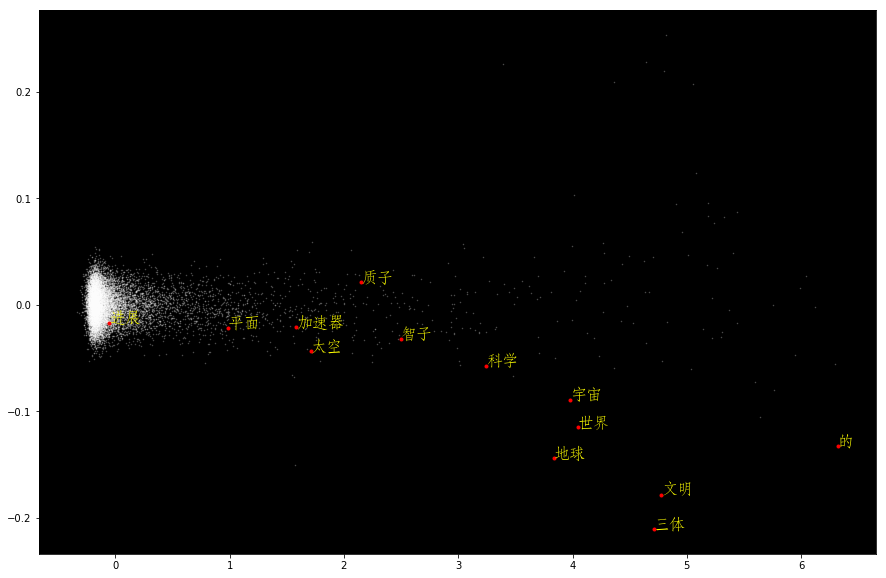

In [22]:
# 绘制星空图
# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.3, color = 'white')


# 绘制几个特殊单词的向量
words = ['智子', '地球', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '进展','的']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'yellow')

### 2、调用一个现成的词向量

1). 大规模词向量可视化

该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量，
下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [10]:
# 加载词向量
word_vectors = KeyedVectors.load_word2vec_format('vectors.bin', binary=True, unicode_errors='ignore')
len(word_vectors.vocab)

1366130

In [25]:
# PCA降维
rawWordVec = []
word2ind = {}
for i, w in enumerate(word_vectors.vocab):
    rawWordVec.append(word_vectors[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

In [26]:
# 查看相似词
word_vectors.most_similar('物理', topn = 20)

[('化学', 0.7124662399291992),
 ('物理化学', 0.6906830072402954),
 ('物理学', 0.6732755899429321),
 ('力学', 0.6633583903312683),
 ('数学', 0.6431227922439575),
 ('电学', 0.6256974935531616),
 ('原理', 0.6226458549499512),
 ('生物学', 0.6126974821090698),
 ('数学物理', 0.6115935444831848),
 ('电化学', 0.6058178544044495),
 ('非线性', 0.595616340637207),
 ('量子力学', 0.5924554467201233),
 ('热学', 0.5854000449180603),
 ('电磁场', 0.5820313096046448),
 ('物理现象', 0.5818398594856262),
 ('凝聚态', 0.5746456384658813),
 ('计算机', 0.569004476070404),
 ('流体力学', 0.5671141147613525),
 ('化学性', 0.563992440700531),
 ('微积分', 0.5628953576087952)]

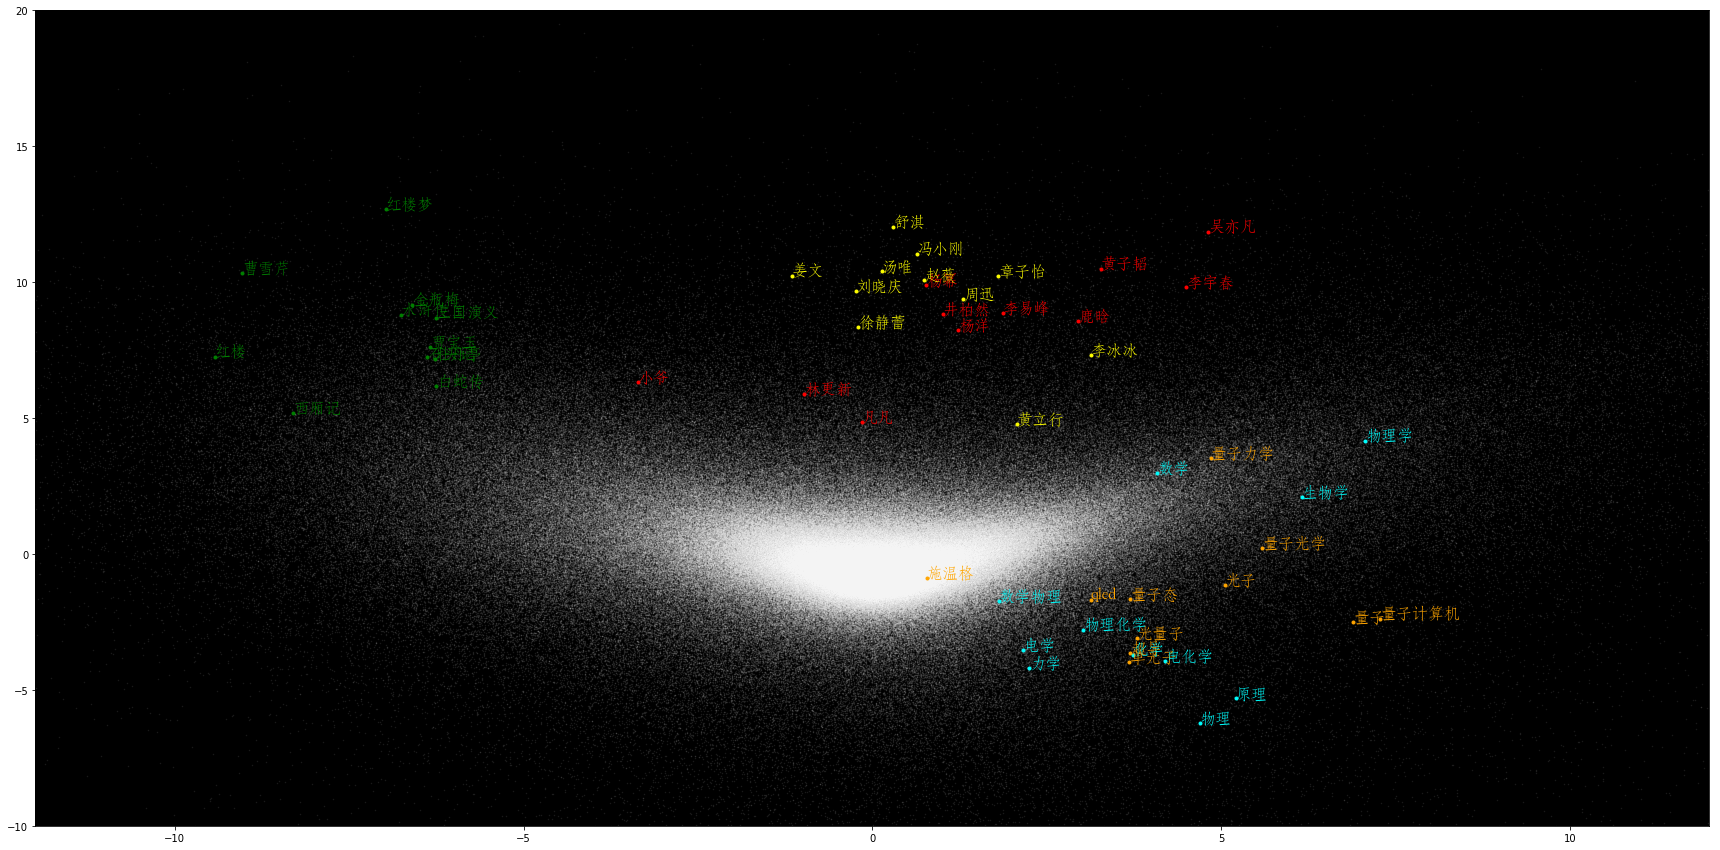

In [27]:
# 绘制星空图
# 绘制所有的词汇
fig = plt.figure(figsize = (30, 15))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.1, color = 'white')

ax.set_xlim([-12,12])
ax.set_ylim([-10,20])


# 选择几个特殊词汇，不仅画它们的位置，而且把它们的临近词也画出来
words = {'徐静蕾','吴亦凡','物理','红楼梦','量子'}
all_words = []
for w in words:
    lst = word_vectors.most_similar(w)
    wds = [i[0] for i in lst]
    metrics = [i[1] for i in lst]
    wds = np.append(wds, w)
    all_words.append(wds)


zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
colors = ['red', 'yellow', 'orange', 'green', 'cyan', 'cyan']
for num, wds in enumerate(all_words):
    for w in wds:
        if w in word2ind:
            ind = word2ind[w]
            xy = X_reduced[ind]
            plt.plot(xy[0], xy[1], '.', alpha =1, color = colors[num])
            plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = colors[num])

#### 2). 类比关系实验

In [28]:
# 女人－男人＝？－国王
words = word_vectors.most_similar(positive=['女人', '国王'], negative=['男人'])
words

[('王后', 0.6745086312294006),
 ('国王队', 0.6190646886825562),
 ('爵士', 0.6134730577468872),
 ('路易十四', 0.6120332479476929),
 ('萨克拉门托', 0.6105179786682129),
 ('莱恩', 0.6097207069396973),
 ('教皇', 0.6067279577255249),
 ('乔治', 0.6061576008796692),
 ('拿破仑', 0.596650242805481),
 ('路易十五', 0.5955969095230103)]

In [29]:
# 北京－中国＝？－俄罗斯
words = word_vectors.most_similar(positive=['北京', '俄罗斯'], negative=['中国'])
words

[('莫斯科', 0.6559879779815674),
 ('明斯克', 0.5312925577163696),
 ('基辅', 0.5114986300468445),
 ('伊尔库茨克', 0.510644793510437),
 ('安卡拉', 0.503899872303009),
 ('哈萨克斯坦', 0.5037742853164673),
 ('白俄罗斯', 0.49618422985076904),
 ('新西伯利亚', 0.49343934655189514),
 ('圣彼得堡', 0.49158066511154175),
 ('加里宁格勒', 0.48882216215133667)]

In [30]:
# 自然科学－物理学＝？－政治学
words = word_vectors.most_similar(positive=['自然科学', '政治学'], negative=['物理学'])
words

[('人文科学', 0.6870070099830627),
 ('社科', 0.6561877727508545),
 ('历史学', 0.6510788202285767),
 ('社会学', 0.6255476474761963),
 ('法学', 0.6240647435188293),
 ('人文学科', 0.6205806136131287),
 ('外交学', 0.615936815738678),
 ('社会科学', 0.6153011322021484),
 ('人类学', 0.6027011871337891),
 ('社科类', 0.6017463207244873)]

In [11]:
# 王菲－章子怡＝？－汪峰
words = word_vectors.most_similar(positive=['王菲', '汪峰'], negative=['章子怡'])
words

[('窦唯', 0.7128487825393677),
 ('窦靖童', 0.6921026706695557),
 ('张韶涵', 0.6702383160591125),
 ('齐秦', 0.642118513584137),
 ('谢霆锋', 0.6239088177680969),
 ('那英', 0.6225878596305847),
 ('哈林', 0.6223201751708984),
 ('李亚鹏', 0.6200003027915955),
 ('张惠妹', 0.615531325340271),
 ('李宗盛', 0.6131705045700073)]

In [12]:
# 尽可能多地选出所有的货币
words = word_vectors.most_similar(positive=['美元', '英镑'], topn = 100)
words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], topn = 100)
#words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], negative = ['原油价格', '7800万'], topn = 100)
words

[('欧元', 0.8743425607681274),
 ('澳元', 0.8102496862411499),
 ('日圆', 0.7611238956451416),
 ('加元', 0.7465020418167114),
 ('人民币', 0.7449039816856384),
 ('美金', 0.7149820923805237),
 ('韩元', 0.7145756483078003),
 ('瑞郎', 0.7067820429801941),
 ('英磅', 0.6967371702194214),
 ('卢布', 0.694721519947052),
 ('卢比', 0.6720969080924988),
 ('镑', 0.6703317761421204),
 ('比索', 0.6515073776245117),
 ('港元', 0.6429406404495239),
 ('马币', 0.6186234951019287),
 ('挪威克朗', 0.6135693788528442),
 ('雷亚尔', 0.6096117496490479),
 ('丹麦克朗', 0.6067554950714111),
 ('美圆', 0.6023485660552979),
 ('美元汇率', 0.6011217832565308),
 ('令吉', 0.5950231552124023),
 ('印尼盾', 0.5935584306716919),
 ('里亚尔', 0.5928155183792114),
 ('新台币', 0.5848963260650635),
 ('澳币', 0.5745424032211304),
 ('欧元也', 0.5737853050231934),
 ('印度卢比', 0.5609548091888428),
 ('金价', 0.5518712401390076),
 ('法郎', 0.551790177822113),
 ('瑞典克朗', 0.5478922128677368),
 ('韩圆', 0.5478326678276062),
 ('台币', 0.5418106317520142),
 ('黄金价格', 0.5329560041427612),
 ('创纪录', 0.5307083129882812)

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码